## Segment a sparse 3D image with a single material component  

The goal of this notebook is to develop a 3D segmentation algorithm that improves segmentation where features are detected.

**Data:** AM parts from Xuan Zhang. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
import time
import seaborn as sns
import pandas as pd

from tomo_encoders import Patches
from tomo_encoders.misc import viewer
from tomo_encoders import DataFile
import cupy as cp
from tomo_encoders.reconstruction.project import get_projections
from tomo_encoders.reconstruction.recon import recon_binning, recon_patches_3d
from tomo_encoders.misc.voxel_processing import cylindrical_mask, normalize_volume_gpu

In [2]:
hf = h5py.File('/data02/MyArchive/aisteer_3Dencoders/tmp_data/projs_2k.hdf5', 'r')
PROJS = np.asarray(hf["data"][:])
THETA = np.asarray(hf["theta"][:])
CENTER = float(np.asarray(hf["center"]))
hf.close()

In [3]:
print(f'projs shape: {PROJS.shape}')

projs shape: (1500, 896, 2176)


In [4]:
N_REPS = 3
b = 2
b_Z = 2
b_K = 2
APPLY_FBP = True

In [5]:
projs = PROJS.copy()
theta = THETA.copy()
center = CENTER
# test
times = []
for ii in range(N_REPS):
    Vx_rec, t_ = recon_binning(projs, theta, center, b_K, b_Z, b, apply_fbp = APPLY_FBP, TIMEIT = True)
    times.append(t_)
print(f'binned shape: {Vx_rec.shape}')
print(f'binned projections: {projs.shape[0]//b_K}')
print(f'median time: {np.median(times):.2f}')

/home/atekawade/anaconda3/envs/tf2GPU/lib/python3.9/site-packages/cupy/fft/_fft.py:152: UserWarning: cuFFT plan cache is disabled on CUDA 11.1 due to a known bug, so performance may be degraded. The bug is fixed on CUDA 11.2+.
  cache = get_plan_cache()


TIME binned reconstruction: 4278.43 ms
TIME binned reconstruction: 3763.43 ms
TIME binned reconstruction: 3772.36 ms
binned shape: (448, 1088, 1088)
binned projections: 750
median time: 3772.36


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

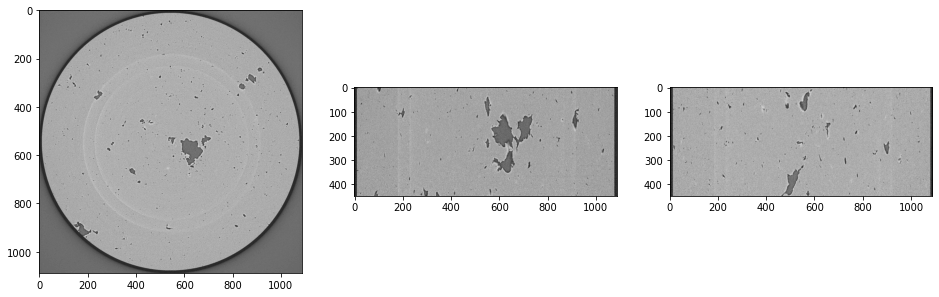

In [6]:
fig, ax = plt.subplots(1,3,figsize=(16,8))
viewer.view_midplanes(Vx_rec, ax = ax)

In [7]:
projs = PROJS[::b_K, ::b_Z, ::b].copy()
theta = THETA[::b_K].copy()
center = CENTER/b
VOL_SHAPE = (projs.shape[1], projs.shape[2], projs.shape[2])
print(f'binned shape: {VOL_SHAPE}')
print(f'binned projections: {projs.shape[0]}')
# test
times = []
for ii in range(N_REPS):
    p3d = Patches(VOL_SHAPE, initialize_by='regular-grid', patch_size=(32,32,32))
    x, p3d, t_ = recon_patches_3d(projs, theta, center, p3d, apply_fbp = APPLY_FBP, TIMEIT = True)
    Vx_rec = np.zeros(VOL_SHAPE, dtype = x.dtype)
    p3d.fill_patches_in_volume(x, Vx_rec)
    times.append(t_)
print(f'median time: {np.median(times):.2f}')

binned shape: (448, 1088, 1088)
binned projections: 750
reconstructing selected 3D patches (32, 32, 32) along 14 z-chunks
TIME reconstruct 3D patches: 14.32 seconds
reconstructing selected 3D patches (32, 32, 32) along 14 z-chunks
TIME reconstruct 3D patches: 14.25 seconds
reconstructing selected 3D patches (32, 32, 32) along 14 z-chunks
TIME reconstruct 3D patches: 14.48 seconds
median time: 14320.58


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

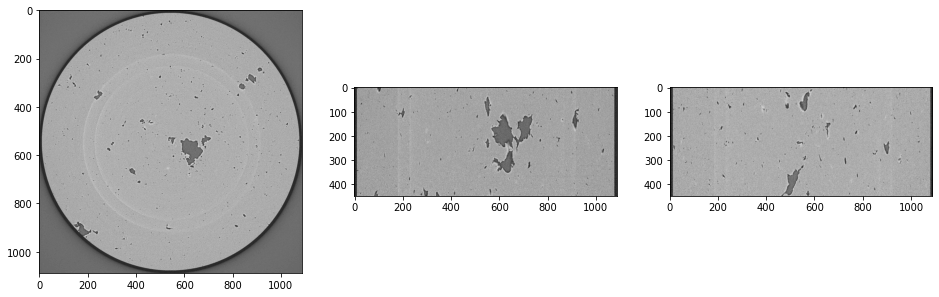

In [8]:
fig, ax = plt.subplots(1,3,figsize=(16,8))
viewer.view_midplanes(Vx_rec, ax = ax)